## 'git clone' this repo and unzip the csv file with minute bar data

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from datetime import datetime
from dateutil import parser
from scipy.stats import norm, t
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

sns.set(rc={'figure.figsize':(11.7,8.27)})

def getData(fname,ccy):
    df = pd.read_csv('/home/ian/Downloads/'+fname,skiprows=0)
    df['date']=pd.to_datetime(df['date'])
    df[ccy]=df.close
    df.rename_axis(None, axis = 1)
    df.set_index(['date'])
    df.sort_index(inplace=True,ascending=False)
    df.drop(columns=['unix','open','high','low','close','symbol','tradecount','Volume USDT'],inplace=True)    
    return df

eth = getData('Binance_ETHUSDT_minute.csv','eth')

eth.reset_index(inplace=True)
eth.date = pd.to_datetime(eth.date)
eth.set_index('date')
eth['ret'] = eth.eth.pct_change()
eth['csum'] = eth.eth.pct_change().cumsum()
eth.dropna(inplace=True,how='any')

def doStrat(datain,lookback=1000,retwindow=60):
    datain.dropna(inplace=True,how='any')
    # exp weighted average return
    datain['vol'] = datain.ret-datain.ret.ewm(span=lookback, adjust=False).mean()
    datain['retma'] = datain.ret.rolling(retwindow).mean()
    datain.dropna(inplace=True,how='any')
    datain['rd1'] = datain['retma']   #datain['vol']
    datain['pos'] = (datain.rd1>0)*1.0
    datain['strat'] = datain['pos'].shift(1) * datain['ret']
    return datain


Data looks good...

In [3]:
eth

,index,date,Volume ETH,eth,ret,csum
1,258945,2020-09-11 20:41:00,274.35788,369.01,0.000868,0.000868
2,258944,2020-09-11 20:42:00,152.76667,368.71,-0.000813,0.000055
3,258943,2020-09-11 20:43:00,75.44480,368.84,0.000353,0.000408
4,258942,2020-09-11 20:44:00,212.69913,368.68,-0.000434,-0.000026
5,258941,2020-09-11 20:45:00,344.32939,369.20,0.001410,0.001384
...,...,...,...,...,...,...
258942,4,2021-03-11 01:02:00,728.56055,1785.75,0.002791,1.897917
258943,3,2021-03-11 01:03:00,580.93479,1775.85,-0.005544,1.892373
258944,2,2021-03-11 01:04:00,406.68479,1774.16,-0.000952,1.891422
258945,1,2021-03-11 01:05:00,440.82793,1773.27,-0.000502,1.890920


<AxesSubplot:>

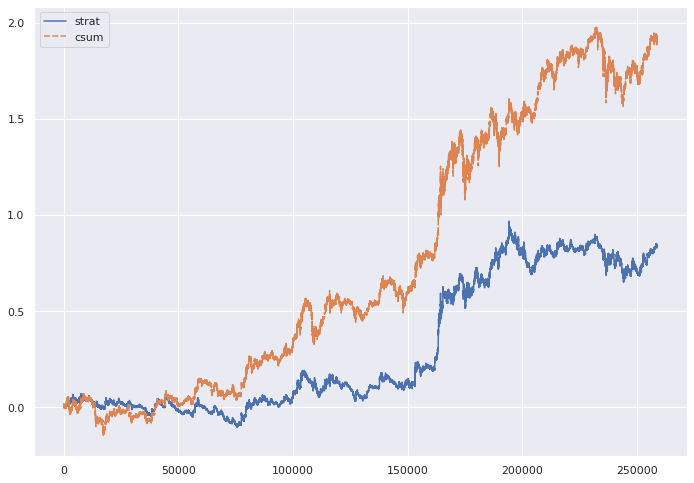

In [4]:
df = doStrat(eth.copy(),1000,50)
sns.lineplot(data=[df.strat.cumsum(),df.csum])

The window parameters are not very good for trend following
But it does give good drawdown protection... Zooming in to 0..50000 sample area

<AxesSubplot:>

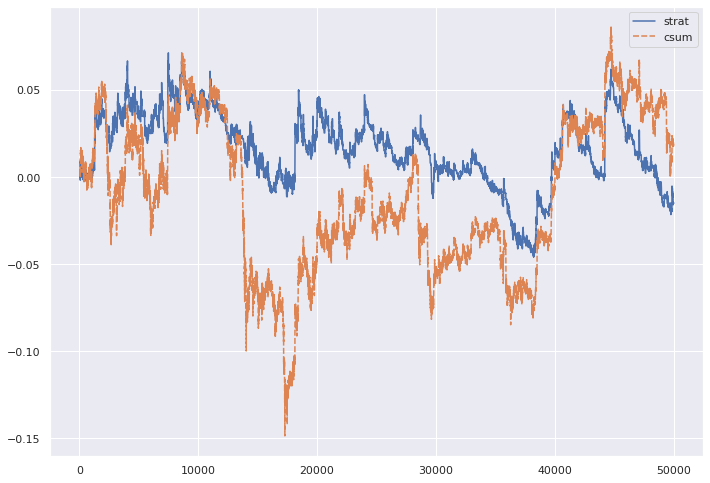

In [5]:
df = doStrat(eth.copy()[:50000],1000,50)
sns.lineplot(data=[df.strat.cumsum(),df.csum])